<a href="https://colab.research.google.com/github/yorkjong/vistock/blob/feature%2Fibd/notebooks/ibd_rs_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Required Packages

In [1]:
%pip install "git+https://github.com/yorkjong/vistock.git@feature/ibd"

  Cloning https://github.com/yorkjong/vistock.git (to revision feature/ibd) to /tmp/pip-req-build-p8peipng
  Running command git clone --filter=blob:none --quiet https://github.com/yorkjong/vistock.git /tmp/pip-req-build-p8peipng
  Running command git checkout -b feature/ibd --track origin/feature/ibd
  Switched to a new branch 'feature/ibd'
  Branch 'feature/ibd' set up to track remote branch 'feature/ibd' from 'origin'.
  Resolved https://github.com/yorkjong/vistock.git to commit 7331420b2dc5918718e9117f0d9db54540cb4893
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.9 MB/s eta 0:00:00
  Created wheel for vistock: filename=vistock-0.4.0-py3-none-any.whl size=55065 sha256=99ffd831f2c186195e0e29f582bed5a41e8fe08d557ee345d50a18e506b5c8ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-or8v94h9/wheels/07/97/7f/a72c7fbc975be0326ac45fec1ca0c872e2d6e2bbea96caf706
Successfully built vistock


### Stock Chart Featuring IBD’s RS Line and its Moving Averages

[*********************100%%**********************]  2 of 2 completed


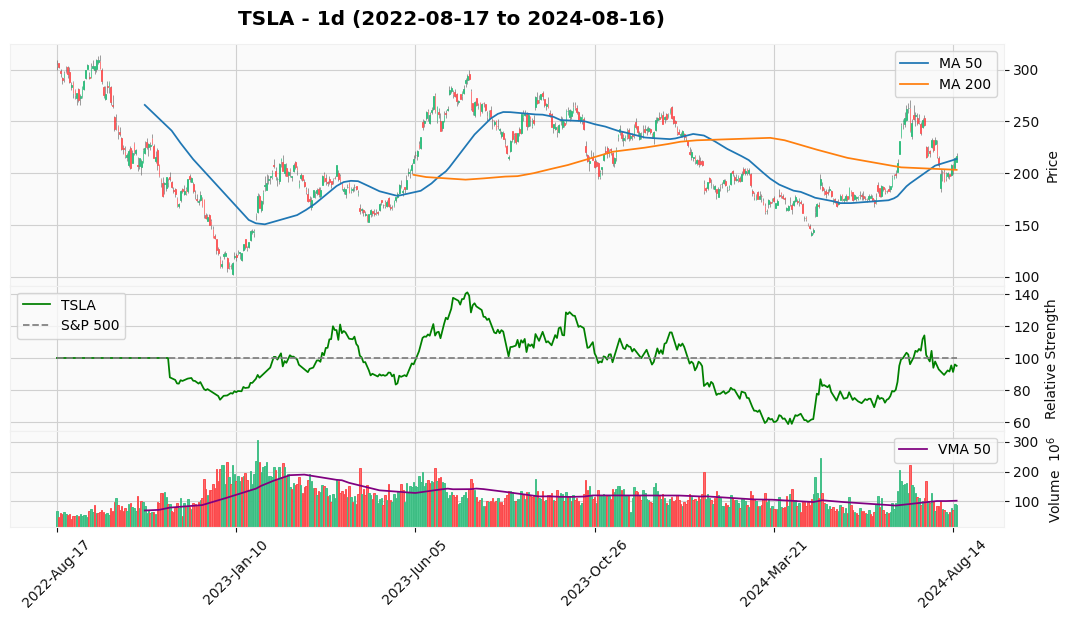

In [2]:
# @title Plot using mplfinance {"run":"auto"}
symbol = "TSLA" #@param ["TSLA", "NVDA", "MSFT", "AAPL", "GOOG", "MSTR", "TQQQ", "SOXL", "TSM", "台積電", "2330", "元太", "BTC-USD", "ETH-USD"] {allow-input: true}
period = "2y" # @param ["1y","2y","5y"]
interval = "1d" # @param ["1d","1wk"]
hides_nontrading = True # @param {"type":"boolean"}
legend_loc = "best" # @param ["best","upper right","upper left","lower left","lower right","right","center left","center right","lower center","upper center","center"]
style = "yahoo" # @param ["yahoo","charles","tradingview","binance","binancedark","mike","nightclouds","checkers","ibd","sas","starsandstripes","kenan","blueskies","brasil"]

from vistock.mpl import ibd_rs

ibd_rs.plot(symbol, period, interval, hides_nontrading=hides_nontrading,
            legend_loc=legend_loc, style=style)

In [3]:
# @title Plot using Plotly {"run":"auto"}
symbol = "TSLA" #@param ["TSLA", "NVDA", "MSFT", "AAPL", "GOOG", "MSTR", "TQQQ", "SOXL", "TSM", "台積電", "2330", "元太", "BTC-USD", "ETH-USD"] {allow-input: true}
period = "2y" # @param ["1y","2y","5y"]
interval = "1d" # @param ["1d","1wk"]
hides_nontrading = True # @param {"type":"boolean"}

from vistock.plotly import ibd_rs

ibd_rs.plot(symbol, period, interval, hides_nontrading=hides_nontrading)

[*********************100%%**********************]  2 of 2 completed


### Comparing Indices with RS Lines

[*********************100%%**********************]  6 of 6 completed


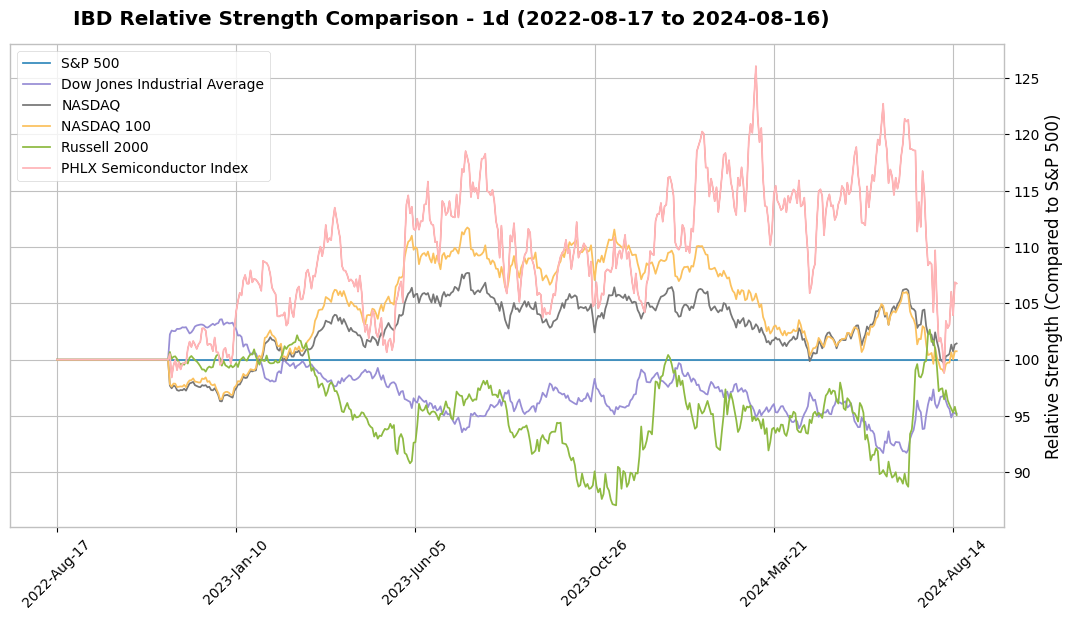

In [4]:
# @title Plot using mplfinance {"run":"auto"}
period = "2y" # @param ["1y","2y","5y"]
interval = "1d" # @param ["1d","1wk"]
hides_nontrading = True # @param {"type":"boolean"}
legend_loc = "best" # @param ["best","upper right","upper left","lower left","lower right","right","center left","center right","lower center","upper center","center"]
style = "checkers" # @param ["yahoo","charles","tradingview","binance","binancedark","mike","nightclouds","checkers","ibd","sas","starsandstripes","kenan","blueskies","brasil"]

from vistock.mpl import ibd_rs_cmp

symbols=["^GSPC", "^DJI", "^IXIC", "^NDX", "^RUT", "^SOX"]
ibd_rs_cmp.plot(symbols, period, interval, hides_nontrading=hides_nontrading,
                legend_loc=legend_loc, style=style)

In [6]:
# @title Plot using Plotly {"run":"auto"}
period = "2y" # @param ["1y","2y","5y"]
interval = "1d" # @param ["1d","1wk"]
hides_nontrading = True # @param {"type":"boolean"}

from vistock.plotly import ibd_rs_cmp

symbols=["^GSPC", "^SOX", "^TWII", "^NDX", "^GDAXI", "^N225", "^HSI"]
ibd_rs_cmp.plot(symbols, period, interval, hides_nontrading=hides_nontrading)

[*********************100%%**********************]  7 of 7 completed
